In [272]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap
from skew_autotransform import skew_autotransform
from category_encoders import OrdinalEncoder
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance, plot_partial_dependence
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [244]:
#Read in data path
data = 'C:/Users/rebel/Downloads/phl_exoplanet_catalog.csv'

In [245]:
#create wrangle function
def wrangle(data):
    
    df = pd.read_csv(data)

    #Drop constant columns
    df.drop(columns=['P_STATUS', 'P_TEMP_MEASURED', 'P_GEO_ALBEDO_ERROR_MIN', 
                     'P_GEO_ALBEDO_ERROR_MAX'], inplace=True)

    #Drop High Cardinality Categorical Variables
    df.drop(columns=['S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG', 'P_NAME', 
                     'P_UPDATED', 'S_NAME', 'S_TYPE', 'S_ALT_NAMES', 'S_RA_T', 'S_DEC_T'], inplace=True)
    
    #Drop columns with missing values greater than 40%
    pct_null = df.isnull().sum() / len(df)
    missing_features = pct_null[pct_null > 0.4].index
    df.drop(missing_features, axis=1, inplace=True)
    
    #Drop negatively skewed columns
    df.drop(columns=['P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_PERIOD_ERROR_MIN',
            'S_MASS_ERROR_MIN', 'S_TEMPERATURE_ERROR_MIN'], inplace=True)
    
    #function to turn conservatively and optimistically habitable into a single binary column
    def binary(habitable):
        if habitable == 0:
            return 0
        else:
            return 1
    
    #Create new column from binary function
    df['HABITABLE'] = df['P_HABITABLE'].apply(binary)
    df.drop(columns=['P_HABITABLE'], inplace=True)
    
    #Drop features with no permutation importance
    df.drop(columns=['P_RADIUS_ERROR_MAX', 'P_FLUX_MAX', 'P_TEMP_EQUIL',
            'P_TEMP_EQUIL_MAX', 'P_TYPE', 'S_RADIUS_EST', 'S_TYPE_TEMP', 'S_RA_H',
            'S_LUMINOSITY', 'S_HZ_OPT_MIN', 'S_HZ_OPT_MAX', 'S_HZ_CON_MIN', 'S_HZ_CON_MAX',
            'S_HZ_CON0_MIN', 'S_HZ_CON0_MAX', 'S_HZ_CON1_MIN', 'S_HZ_CON1_MAX', 'S_SNOW_LINE',
            'S_ABIO_ZONE', 'P_HABZONE_CON', 'P_TYPE_TEMP', 'P_MASS_EST', 'P_DISTANCE_EFF',
            'P_SEMI_MAJOR_AXIS_EST', 'P_PERIASTRON', 'S_MAG', 'P_DETECTION', 'S_DISTANCE_ERROR_MIN',
            'S_DISTANCE_ERROR_MAX', 'P_APASTRON', 'S_METALLICITY_ERROR_MIN', 'S_METALLICITY_ERROR_MAX',
            'P_PERIOD_ERROR_MAX', 'S_DEC', 'S_MASS_ERROR_MAX', 'S_RADIUS_ERROR_MIN', 
            'S_RADIUS_ERROR_MAX', 'S_TEMPERATURE', 'P_PERIOD', 'S_TEMPERATURE_ERROR_MAX', 
            'S_LOG_G', 'P_DISTANCE', 'P_YEAR','S_RADIUS', 'S_RA'], inplace=True)
    
    return df

In [246]:
#Run wrangle function to create dataframe
df = wrangle(data)

In [247]:
df.head()

,S_DISTANCE,S_METALLICITY,S_MASS,P_FLUX,P_FLUX_MIN,P_TEMP_EQUIL_MIN,S_TIDAL_LOCK,P_ESI,P_RADIUS_EST,HABITABLE
0,93.37,-0.35,2.70,101.011410,64.855456,722.98875,0.642400,0.083813,12.082709,0
1,125.72,-0.02,2.78,107.351180,91.741348,788.47184,0.648683,0.082414,12.229641,0
2,75.59,-0.24,2.20,84.446427,84.446427,772.30746,0.600010,0.081917,12.848516,0
3,17.94,0.41,0.90,0.078887,0.039047,113.25125,0.445415,0.145241,12.865261,0
4,21.15,0.06,1.08,0.618972,0.160799,161.33012,0.473325,0.368627,13.421749,0


In [248]:
#Split data into target variable y, and data X
target = 'HABITABLE'
y = df[target]
X = df.drop(columns=[target])

In [249]:
#Ordinally encode categorical columns
enc = OrdinalEncoder()
X = enc.fit_transform(X)

In [250]:
#Run Iterative Imputer to replace all missing values
imp_mean = IterativeImputer(random_state=42)
X[:] = imp_mean.fit_transform(X)

In [251]:
#Split data into training, validation, and test sets
# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.6
ratio_val = 0.2
ratio_test = 0.2

# Produce test split.
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size=ratio_test)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produce train and val splits.
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=ratio_val_adjusted)

In [252]:
#Oversample our minority classes using SMOTE (only on the training data)
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [253]:
#Run function to transform skewed columns
skew_autotransform(X_train_res, exclude = ['S_METALLICITY'], threshold=24, exp=True)
    

,S_DISTANCE,S_METALLICITY,S_MASS,P_FLUX,P_FLUX_MIN,P_TEMP_EQUIL_MIN,S_TIDAL_LOCK,P_ESI,P_RADIUS_EST
0,1226.000000,-0.030000,0.950000,0.953729,0.953729,323.366270,0.446158,0.545737,2.735240
1,1157.000000,0.030000,1.070000,6.607047,6.607047,1328.911000,0.450202,0.059090,15.794890
2,1362.180000,-0.018181,0.770280,3.577560,3.577560,623.122600,0.411198,0.331212,0.964060
3,948.980000,0.000930,0.852984,3.794643,3.794643,657.874480,0.428703,0.246930,2.768870
4,379.000000,0.140000,1.210000,1.273564,1.273564,350.284080,0.411399,0.282680,11.826550
...,...,...,...,...,...,...,...,...,...
4783,427.784814,-0.211715,0.743515,0.022563,0.022563,255.749538,0.401936,0.805525,1.727692
4784,8.690914,-0.242010,0.337163,-0.670185,-0.697987,211.339309,0.309362,0.655981,2.076353
4785,242.496893,0.002484,0.609979,0.210195,-0.156127,244.899637,0.371224,0.750793,1.966338
4786,413.938899,-0.248373,0.731121,-0.469212,-0.469212,223.529163,0.410105,0.731676,1.586814


In [278]:
#Take a look at our training data pandas profile to check for any outstanding issues
ProfileReport(X_train_res, minimal=True)

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [254]:
#Get baseline accuracy for our training set
baseline_acc = y_train_res.value_counts(normalize=True).max()
print(baseline_acc)

0.5


In [275]:
#Run logistic regression model on our resampled training data
model_logr =  make_pipeline(StandardScaler(), 
                            LogisticRegression()
                           )

model_logr.fit(X_train_res, y_train_res);

In [276]:
#Get Mean Absolute Error for validation and test sets
val_acc = model_logr.score(X_val, y_val)
test_acc = model_logr.score(X_test, y_test)

print('Validation MAE:', val_acc)
print('Test MAE:', test_acc)

Validation MAE: 0.9938271604938271
Test MAE: 0.9925925925925926


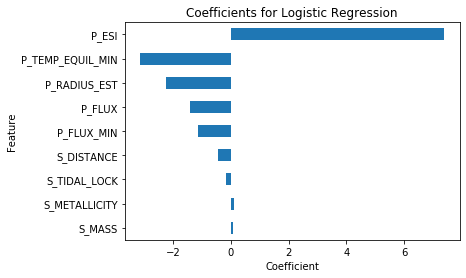

In [277]:
#Create horizontal bar chart showing regression coefficients
coefficients = model_logr.named_steps['logisticregression'].coef_.flatten()
features = X_train_res.columns
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Logistic Regression');

In [255]:
#Run random forest classifier on our resampled training data
model_rf = RandomForestClassifier(n_estimators=50,
                                  n_jobs=-1,
                                  random_state=42)

model_rf.fit(X_train_res, y_train_res);

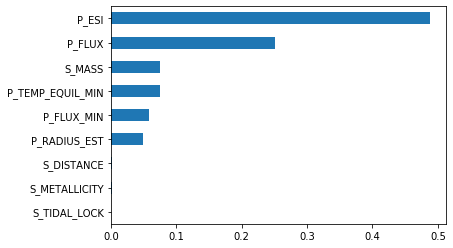

In [256]:
#Plot feature importances for the random forest classifier model
importances = model_rf.feature_importances_
features = X_train_res.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

In [257]:
#Get random forest model validation set accuracy score
val_acc = accuracy_score(y_val, model_rf.predict(X_val))
print(val_acc)

0.9851851851851852


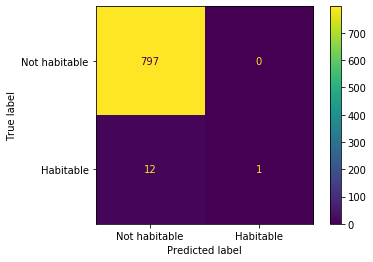

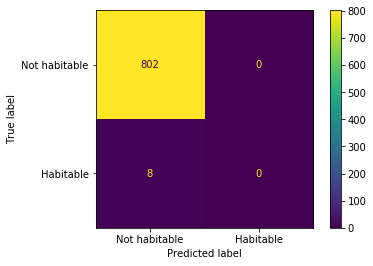

In [258]:
#Create confusion matrix for validation set
plot_confusion_matrix(model_rf,
                      X_val,
                      y_val,
                      values_format='.0f',
                      display_labels=['Not habitable', 'Habitable']);

#Create confusion matrix for test set
plot_confusion_matrix(model_rf,
                      X_test,
                      y_test,
                      values_format='.0f',
                      display_labels=['Not habitable', 'Habitable']);

In [259]:
#Create classification report for the test data
print(classification_report(y_test, model_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       802
           1       0.00      0.00      0.00         8

    accuracy                           0.99       810
   macro avg       0.50      0.50      0.50       810
weighted avg       0.98      0.99      0.99       810



AUC =  0.9971165835411472


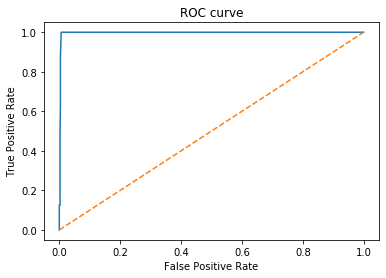

In [260]:
#Create ROC curve for test set and calculate AUC score
y_pred_prob = model_rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roccurve_df = pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

plt.plot(fpr, tpr)
plt.plot([0,1], ls='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

print('AUC = ', roc_auc_score(y_test, y_pred_prob))

In [261]:
#Create XGBoost model
model_xgb = XGBClassifier(n_jobs=-1, random_state=42)

model_xgb.fit(X_train_res, y_train_res);

[07:47:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [262]:
#Get XGBoost validation set accuracy score
xgb_acc = accuracy_score(y_val, model_xgb.predict(X_val))
print(xgb_acc)

0.9864197530864197


In [263]:
#Get permutation importances
perm_imp = permutation_importance(model_xgb,
                                 X_val,
                                 y_val,
                                 n_repeats=5,
                                 n_jobs=-1,
                                 random_state=42)

In [264]:
#Create dataframe containing permutation importances
perm_data = {'imp_mean' : perm_imp['importances_mean'],
            'imp_std' : perm_imp['importances_std']}

perm_df = pd.DataFrame(perm_data, index=X_val.columns).sort_values('imp_mean')

In [265]:
#View permutation imprtances dataframe
perm_df

,imp_mean,imp_std
S_DISTANCE,0.000000,0.000000
S_METALLICITY,0.000000,0.000000
S_MASS,0.000000,0.000000
P_FLUX_MIN,0.000000,0.000000
P_TEMP_EQUIL_MIN,0.000000,0.000000
S_TIDAL_LOCK,0.000000,0.000000
P_FLUX,0.001481,0.000924
P_RADIUS_EST,0.001481,0.000924
P_ESI,0.002469,0.000000


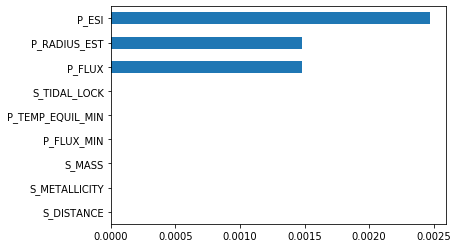

In [266]:
#Plot permutation importances
perm_df['imp_mean'].tail(10).plot(kind='barh');

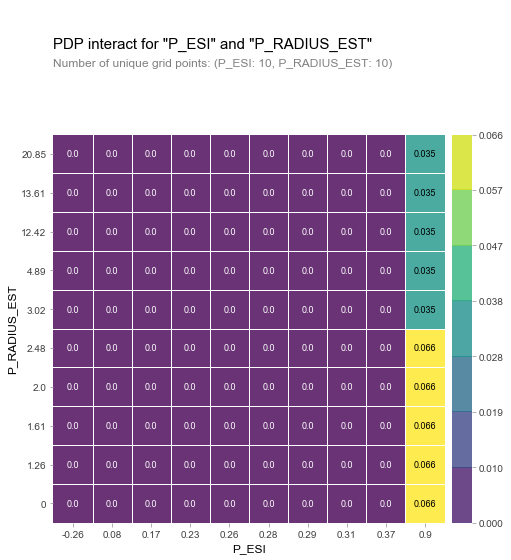

In [267]:
#Create partial dependence plot
features = ['P_ESI', 'P_RADIUS_EST']

interact = pdp_interact(
model_xgb,
dataset=X_val,
model_features= X_val.columns,
features=features)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

In [268]:
#Create Shapley force-plot
row = X_val.loc[X_val.index == 2953]
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
base_value=explainer.expected_value,
shap_values=shap_values,
features=row)

[07:47:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1238: Empty dataset at worker: 0


IndexError: index 0 is out of bounds for axis 0 with size 0